In [6]:
from ppget.source import ModelSource

start_date = "2008-07-01"
end_date = "2010-07-01"
feature = "Global_active_power"

source = ModelSource.load(start_date, end_date, feature)
missing_days = set(source.missing_data().index.date)
missing_days

{datetime.date(2009, 6, 13),
 datetime.date(2009, 6, 14),
 datetime.date(2009, 6, 15),
 datetime.date(2009, 8, 13),
 datetime.date(2010, 1, 12),
 datetime.date(2010, 1, 13),
 datetime.date(2010, 1, 14),
 datetime.date(2010, 3, 20),
 datetime.date(2010, 3, 21)}

In [ ]:
source.sesonal_repalce_days(missing_days)
source.missing_data()

In [3]:
series = source.series()
series.head()

timestamp
2008-07-01 00:00:00    0.6220
2008-07-01 00:10:00    0.2012
2008-07-01 00:20:00    0.1940
2008-07-01 00:30:00    0.5810
2008-07-01 00:40:00    0.2834
Freq: 10T, Name: Global_active_power, dtype: float64

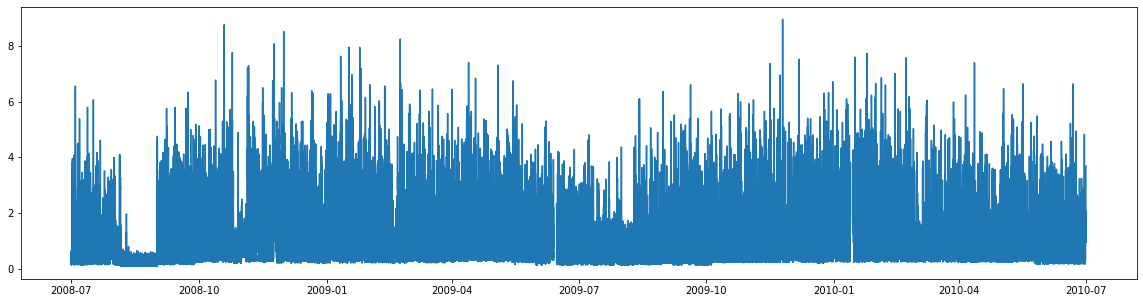

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20,5))
ax.plot(series, label="Ground Truth")

plt.show()